In [1]:
import tensorflow as tf

# Load cifar dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

2024-06-12 16:47:44.702185: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-12 16:47:45.349993: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
tf.config.list_physical_devices('GPU')

2024-06-12 16:47:46.400974: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-12 16:47:46.421715: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-12 16:47:46.421759: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
x_train.shape

(50000, 32, 32, 3)

In [4]:
# Normalization
x_train, x_test = x_train / 255.0, x_test / 255.0

In [5]:
y_train_categorical = tf.keras.utils.to_categorical(y_train, num_classes=10)
y_test_categorical = tf.keras.utils.to_categorical(y_test, num_classes=10)

In [6]:
num_classes = 10
input_shape = (32, 32, 3)

# Define Hyperparameter
# ViT Base
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 64
num_epochs = 20  # For real training, use num_epochs=100. 10 is a test value
image_size = 72  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 12
final_dropout_layer = 0.4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 12
mlp_head_units = [
    3072,
]

config_json = {   
    "learning_rate" : learning_rate,
    "batch_size" : batch_size,
    "num_epochs" : num_epochs,
    "image_size" : image_size,
    "patch_size" : patch_size,
    "num_patches" : num_patches,
    "projection_dim" : projection_dim,
    "num_heads" : num_heads,
    "final_dropout_layer" : final_dropout_layer,
    "transformer_units" : transformer_units,
    "transformer_layers" : transformer_layers,
    "mlp_head_units" : mlp_head_units
}

In [7]:
from modules.vision_transformers.patches import Patches
from modules.vision_transformers.patch_encoder import PatchEncoder, mlp

# Data Augmentation for resize
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.Normalization(),
    tf.keras.layers.Resizing(image_size, image_size),
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(factor=0.02),
    tf.keras.layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    tf.keras.layers.RandomContrast(factor=0.1)
])

# Compute the average and variance of the training data for normalization purpose
data_augmentation.layers[0].adapt(x_train)

2024-06-12 16:47:46.797568: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-12 16:47:46.797662: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-12 16:47:46.797693: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-12 16:47:47.774657: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-12 16:47:47.774770: I external/local_xla/xla/stream_executor

In [8]:
# Define the model
def create_classifier():
    # Inputs for CNN
    inputs_cnn = tf.keras.layers.Input(shape=input_shape)

    x = tf.keras.layers.Conv2D(128, kernel_size=(3, 3), strides=(2, 2), activation='relu', padding='same')(inputs_cnn)
    x = tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='same')(x)
    x = tf.keras.layers.Conv2D(64, kernel_size=(3, 3), strides=(2, 2), activation='relu', padding='same')(x)
    x = tf.keras.layers.Conv2D(64, kernel_size=(3, 3), strides=(2, 2), activation='relu', padding='same')(x)
    x = tf.keras.layers.Dropout(0.1)(x)
    x = tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='same')(x)
    x = tf.keras.layers.Conv2D(64, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding='same')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    outputs_cnn = tf.keras.layers.Flatten()(x)
    
    # Input for Transformer
    inputs_transformers = tf.keras.Input(shape=input_shape)
    
    # Apply augment resize
    augmented = data_augmentation(inputs_transformers)
    
    # Create Patches
    patches = Patches(patch_size)(augmented)

    # Encode every patches position
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    for _ in range(transformer_layers):
        # Create multilayers about how many transformers layer needed
        x1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    
        # Create a multi-head attention layer
        attention_output = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)

        # Skip connection 1
        x2 = tf.keras.layers.Add()([attention_output, encoded_patches])

        # layer normalization 2
        x3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x2)

        # NLP
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)

        # Skip Connection
        encoded_patches = tf.keras.layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = tf.keras.layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = tf.keras.layers.Flatten()(representation)
    representation_transformers = tf.keras.layers.Dropout(final_dropout_layer)(representation)

    # Concat
    concatenated = tf.keras.layers.Concatenate()([outputs_cnn, representation_transformers])
    
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=final_dropout_layer)
    
    # Classify outputs.
    logits = tf.keras.layers.Dense(num_classes)(concatenated)
    # Create the Keras model.
    model = tf.keras.Model(inputs=[inputs_cnn, inputs_transformers], outputs=logits)
    
    return model

model = create_classifier()

In [9]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 72, 72, 3) │          7 │ input_layer_1[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patches (Patches)   │ (None, 144, 108)  │          0 │ sequential[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patch_encoder       │ (None, 144, 64)   │     16,192 │ patches[0][0]     │
│ (PatchEncoder)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 144, 64)   │        128 │ patch_encoder[0]… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 144, 64)   │    198,976 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 144, 64)   │          0 │ multi_head_atten… │
│                     │                   │            │ patch_encoder[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 144, 64)   │        128 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 144, 128)  │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 144, 128)  │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 144, 64)   │      8,256 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 144, 64)   │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 144, 64)   │          0 │ dropout_4[0][0],  │
│                     │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 144, 64)   │        128 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 144, 64)   │    198,976 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 144, 64)   │          0 │ multi_head_atten… │
│                     │                   │            │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 144, 64)   │        128 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 144, 128)  │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 144, 128)  │          0 │ dense_3[0][0]   

 Total params: 2,850,065 (10.87 MB)

 Trainable params: 2,850,058 (10.87 MB)

 Non-trainable params: 7 (32.00 B)

In [10]:
total_steps = len(x_train) * num_epochs
decay_steps = total_steps * 0.4
# Cosine Learning Rate Decay
cosine_decay_scheduler = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=learning_rate,
    decay_steps=decay_steps,
    alpha=0.1,
    warmup_steps=15000
)

In [11]:
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=cosine_decay_scheduler),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=[
        tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
        tf.keras.metrics.TopKCategoricalAccuracy(3, name='top-3-accuracy')
    ]
)

In [12]:
history = model.fit(
    x=[x_train, x_train],
    y=y_train_categorical,
    batch_size=batch_size,
    epochs=num_epochs,
    validation_data=([x_test, x_test], y_test_categorical)
)

Epoch 1/20


2024-06-12 16:48:15.220424: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_2_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-06-12 16:48:20.121800: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8906


782/782 ━━━━━━━━━━━━━━━━━━━━ 261s 291ms/step - accuracy: 0.2663 - loss: 2.3823 - top-3-accuracy: 0.5744 - val_accuracy: 0.4815 - val_loss: 1.4379 - val_top-3-accuracy: 0.8034
Epoch 2/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 227s 290ms/step - accuracy: 0.4830 - loss: 1.4084 - top-3-accuracy: 0.8091 - val_accuracy: 0.5248 - val_loss: 1.2995 - val_top-3-accuracy: 0.8366
Epoch 3/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 253s 324ms/step - accuracy: 0.5461 - loss: 1.2526 - top-3-accuracy: 0.8468 - val_accuracy: 0.5625 - val_loss: 1.2225 - val_top-3-accuracy: 0.8498
Epoch 4/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 227s 291ms/step - accuracy: 0.5924 - loss: 1.1373 - top-3-accuracy: 0.8735 - val_accuracy: 0.5699 - val_loss: 1.1934 - val_top-3-accuracy: 0.8567
Epoch 5/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 233s 298ms/step - accuracy: 0.6149 - loss: 1.0722 - top-3-accuracy: 0.8879 - val_accuracy: 0.5884 - val_loss: 1.1700 - val_top-3-accuracy: 0.8590
Epoch 6/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 305s 391ms/step - accuracy: 0.6447 - loss

In [13]:
evaluated = model.evaluate([x_test, x_test], y_test_categorical)
final_acc, final_loss, final_top_3_acc = evaluated[0], evaluated[1], evaluated[2]

313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - accuracy: 0.6626 - loss: 1.0096 - top-3-accuracy: 0.9035


In [14]:
save_name = 'model/model_val_acc_75_'

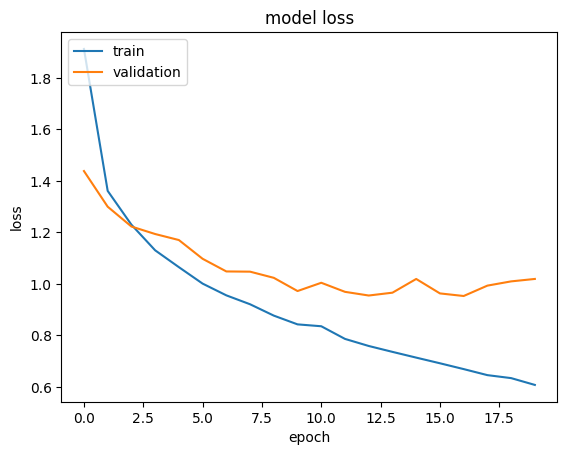

In [15]:
import matplotlib.pyplot as plt

# Save Train result
fig = plt.gcf()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()



In [16]:
fig.savefig(save_name + "_loss.jpg")

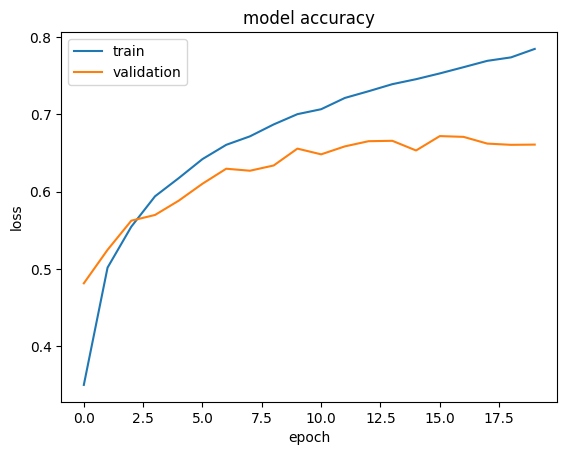

In [18]:
# Save Train result
fig = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [19]:
fig.savefig(save_name + "_accuracy.jpg")

In [20]:
model.save('{}.keras'.format(save_name))

In [21]:
import json

config_json['final_accuracy'] = final_acc
config_json['final_loss'] = final_loss
config_json['final_top_3_acc'] = final_top_3_acc
with open('{}_config.json'.format(save_name), 'w') as f:
    json.dump(config_json, f, indent=4)